# 02 Q-agent

#### 👉Let's use Q-learning to train a smart taxi driver.

#### 👉A smart taxi driver should incur no penalties (i.e. no crashes) and minimize the timesteps to complete the ride.

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
%config InlineBackend.figure_format = 'svg'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Environment 🌎

In [2]:
import gymnasium as gym
env = gym.make("Taxi-v3", render_mode="ansi")

## Q-agent 🤖🧠

In [3]:
import numpy as np

class QAgent:

    def __init__(self, env, alpha, gamma):
        self.env = env

        # table with q-values: n_states * n_actions
        self.q_table = np.zeros([env.observation_space.n,
                                 env.action_space.n])

        # hyper-parameters
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor

    def get_action(self, state):
        """"""
        return np.argmax(self.q_table[state])

    def update_parameters(self, state, action, reward, next_state):
        """"""
        # Q-learning formula
        old_value = self.q_table[state, action]
        next_max = np.max(self.q_table[next_state])
        new_value = \
            old_value + \
            self.alpha * (reward + self.gamma * next_max - old_value)

        # update the q_table
        self.q_table[state, action] = new_value

In [4]:
# hyper-parameters
# RL problems are full of these hyper-parameters.
# For the moment, trust me when I set these values.
# We will later play with these and see how they impact learning.
alpha = 0.1
gamma = 0.6

agent = QAgent(env, alpha, gamma)

## Training loop 🎡

In [5]:
import random
from tqdm import tqdm

# exploration vs exploitation prob
epsilon = 0.1

n_episodes = 10000

# For plotting metrics
timesteps_per_episode = []
penalties_per_episode = []


for i in tqdm(range(0, n_episodes)):
    
    state, _ = env.reset()

    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    while not done:
        
        if random.uniform(0, 1) < epsilon:
            # Explore action space
            action = env.action_space.sample()
        else:
            # Exploit learned values
            action = agent.get_action(state)
        
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        
        agent.update_parameters(state, action, reward, next_state)
        
        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1
        
    timesteps_per_episode.append(epochs)
    penalties_per_episode.append(penalties)

100%|██████████| 10000/10000 [00:02<00:00, 3973.46it/s]


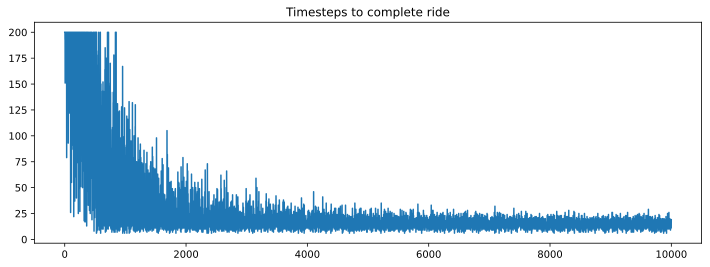

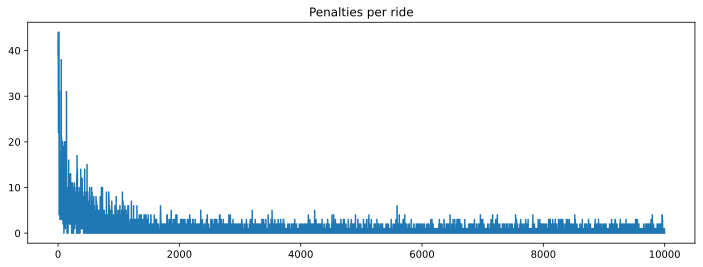

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Timesteps to complete ride")    
pd.Series(timesteps_per_episode).plot(kind='line')
plt.show()

fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Penalties per ride")    
pd.Series(penalties_per_episode).plot(kind='line')
plt.show()

## Let's evaluate this driver starting from a fixed `state = 123`

In [7]:
# set initial state of the environment
state, _ = env.reset(seed=123)

epochs = 0
penalties = 0
reward = 0

# store frames to latter plot them
frames = []

done = False

while not done:
    
    action = agent.get_action(state)
    
    next_state, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    if reward == -10:
        penalties += 1
    
    frames.append({
        'frame': env.render(),
        'state': state,
        'action': action,
        'reward': reward
        }
    )

    state = next_state

    epochs += 1
    
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

Timesteps taken: 15
Penalties incurred: 0


In [18]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1} of {len(frames)}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.1)
        
print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 15 of 15
State: 97
Action: 5
Reward: 20


## Let's evaluate this trained agent on 100 episodes

In [9]:
import random
from tqdm import tqdm

# exploration vs exploitation prob
epsilon = 0.05

n_episodes = 100

# For plotting metrics
timesteps_per_episode = []
penalties_per_episode = []


for i in tqdm(range(0, n_episodes)):
    
    state, _ = env.reset()      
    
    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    while not done:
        
        if random.uniform(0, 1) < epsilon:
            # Explore action space
            action = env.action_space.sample()
        else:
            # Exploit learned values
            action = agent.get_action(state)
        
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
                              
        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1
            
    timesteps_per_episode.append(epochs)
    penalties_per_episode.append(penalties)

100%|██████████| 100/100 [00:00<00:00, 6844.16it/s]


In [10]:
print(f'Avg steps to complete ride: {np.array(timesteps_per_episode).mean()}')
print(f'Avg penalties to complete ride: {np.array(penalties_per_episode).mean()}')

Avg steps to complete ride: 18.49
Avg penalties to complete ride: 0.3
